This notebook is a tutorial of the qutip-cntrl quantum optimal control library, found [here](https://github.com/qutip/qutip-qtrl). I used [this](https://nbviewer.org/github/qutip/qutip-notebooks/blob/master/examples/control-pulseoptim-CRAB-2qubitInerac.ipynb) tutorial via [QuTiP](https://qutip.readthedocs.io/en/master/index.html) to explore the package. The goal here is to calculate control fields needed to transfer a 2-Qubit system from the state 
$$
\begin{pmatrix}
1 & 0 & 0 & 0
\end{pmatrix}^\top
$$ to the state
$$
\begin{pmatrix}
0 & 0 & 0 & 1
\end{pmatrix}^\top
$$
using the Chopped Random Basis
[CRAB](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.106.190501) algorithm.

In [142]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import shutil

In [143]:
from qutip import Qobj, identity, sigmax, sigmaz, core, tensor, identity
#QuTiP control modules
import qutip.control.pulseoptim as cpo

In [144]:
# Random seed and create variables for Pauli matrices + identity matrix for ease of use 
random.seed(20)
sx = sigmax()
sz = sigmaz()
I = identity(2)

We make use of the following combined Hamiltonian to our system:
$$H(t) = H_0 + \sum_{j=1}(u_1(t)H_{c_1} + u_2(t)H_{c_2})$$
We define our control Hamiltonian, $H_c$, as z-rotations of the 2 qubits: $$H_c = \sigma_z \otimes \sigma_z$$
We define our drift Hamiltonian, $H_d$ as $$H_d = \alpha_1(\sigma_x \otimes I) + \alpha_2(I \otimes \sigma_x) + \beta_1(\sigma_z \otimes I) + \beta_2(I \otimes \sigma_z)$$
where $\alpha_i$, $\beta_i$ are randomly initialized coefficients that are to be optimized.

In [145]:
# Define # of controls & Initialize coefficients as described above to be optimized, 
n_cntrl = 2
alpha = [random.random()] * n_cntrl
beta = [random.random()] * n_cntrl

In [146]:
# Control Hamiltonian
H_c = [tensor(sz, sz)]
# Drift Hamiltonian
H_d = (alpha[0]*tensor(sx, I)) + (alpha[1]*tensor(I, sx)) + (beta[0]*tensor(sz, I)) + (beta[1]*tensor(I,sz))

In [147]:
# Initial and target states for qubit 1 and 2 (q1, q2)
q1_0 = Qobj([[1], [0]]) # Qubit 1 initial state
q2_0 = Qobj([[1], [0]]) # Qubit 2 initial state
q1_t = Qobj([[0], [1]]) # Qubit 1 target state
q2_t = Qobj([[0], [1]]) # Qubit 2 target state
psi_0 = tensor(q1_0, q2_0) # combined initial state
psi_t = tensor(q1_t, q2_t) # combined targetr state

In [148]:
# Define evolution parameters
M = 100 # number of time slots
T = 18 # total evolution time

In [149]:
# Define thresholds for process termination
fidelity_threshold = 1e-3 # fidelity error threshold
max_iterations = 500
max_time = 120 # (seconds)

In [150]:
# Define pulse type (qutip-control options are: RND, DEF, LIN, ZERO, SINE, SQUARE, TRIANGLE, SAW)
pulse_type = 'DEF'

In [151]:
# Create an output file extension using our parameters
output_file_extension = f"CRAB_M_{M}_T_{T}_Pulse_{pulse_type}.txt"

In [152]:
# Run optimization with qutip-ctrl
result = cpo.opt_pulse_crab_unitary(H_d, H_c, psi_0, psi_t, M, T, fid_err_targ=fidelity_threshold, 
            max_iter=max_iterations, max_wall_time=max_time, init_coeff_scaling=5.0, num_coeffs=5, 
            method_params={'xtol':1e-3}, guess_pulse_type=None, guess_pulse_action='modulate',
            out_file_ext=output_file_extension, gen_stats=True)

In [153]:
# Housekeeping - Reorganize files (QuTiP-control enforces a specific filepath)
working_dir = os.getcwd() + '/' # get working directory
# Get initial amplitudes output file
initial_path_pre = 'ctrl_amps_initial_'
initial_source = working_dir + initial_path_pre + output_file_extension
# Get final amplitudes output file
final_path_pre = 'ctrl_amps_final_'
# Move both optimization output files to result directory
final_source = working_dir + final_path_pre + output_file_extension
destination = working_dir + 'optim_results/CRAB/'
shutil.move(initial_source, destination)
shutil.move(final_source, destination)

'/Users/lukeandreesen/quantum_computing/quantum_optimal_control/optim_results/CRAB/ctrl_amps_final_CRAB_M_100_T_18_Pulse_DEF.txt'

## Optimization Results:

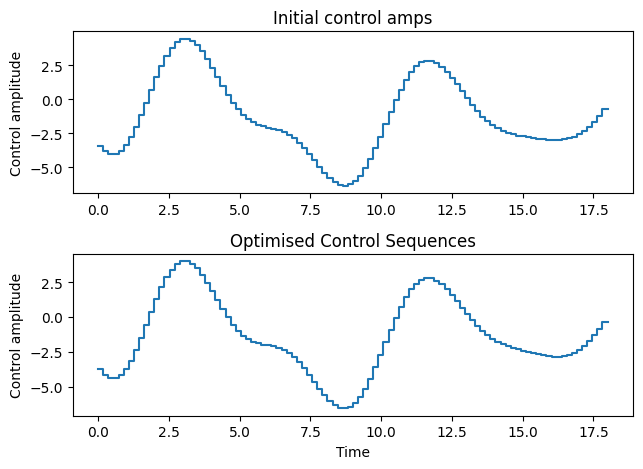

In [157]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial control amps")
#ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
ax1.step(result.time,
         np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])),
         where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
ax2.step(result.time,
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])),
         where='post')
plt.tight_layout()
plt.show()

## Optimization process data:

In [158]:
result.stats.report()


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.170650
Wall time computing Hamiltonians: 0:00:00.030604 (17.93%)
Wall time computing propagators: 0:00:00.120694 (70.73%)
Wall time computing forward propagation: 0:00:00.005148 (3.02%)
Wall time computing onward propagation: 0:00:00.005151 (3.02%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 107
Number of fidelity function calls: 157
Number of times fidelity is computed: 157
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 157

**** Control amplitudes ****
Number of control amplitude updates: 156
Mean number of updates per iteration: 1.4579439252336448
Number of timeslot values changed: 15599
Mean number of timeslot changes per update: 99.99358974358974
Number of amplitude values change